<a href="https://colab.research.google.com/github/MANicholson/Figures-Modelling-and-Simulation-of-a-CMOS-Synapse-Implementing-Two-phase-Plasticity/blob/main/Figure_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Imports
import random
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [ ]:
# Calcium:
I_INDC = 25 * 10**(-12)
i_pre = 700 * 10**(-12)
i_post = 100 * 10**(-12)
tau_DPI = 4.88 * 10**(-3) #<--- This works for a dt of 0.001
I_TH = 10 * 10**(-12)
I_TAU = 20 * 10**(-12)
ica_0 = 17 * 10**(-12)
delta_capre = 60 * 10**(-12)
delta_capost = 15 * 10**(-12)

# Early-phase:
C = 1.2215 * 10**(-11)
v_H0 = 0.9 # [V] V_H0 = 1/2 * V_DD (page 30 Jorge)
I_THPOT = 62 * 10**(-12)
I_THDEP = 39.5 * 10**(-12)
I_TAILP = 50 * 10**(-12)
I_TAILD = 10 * 10**(-12)
i_hrp = 2.5 * 10**(-15)
i_hrn = 2.5 * 10**(-15)
v_h0 = 900 * 10**(-3) # [V] !!!!!!!!!!! NOT 100% sure about this, just taking it from figure 6.2 page 47)
z_0 = 0
V_DD = 1.8 # [V]
# Late phase:
# Here will need to define constants to make the circuit code (early-phase part) compatible with the differential equation late-phase code


# Defining functions

In [ ]:
def calc_concentration_current(tau_DPI, t_spike_pre, t_spike_post, dt, t_array, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0=0):
    """
    Calculate calcium concentration (expressed as a current i_ca) over time.

    Args:
        tau_DPI (float): Time constant for differential pair integrator (DPI).
        t_spike_pre (list): List indicating presynaptic spike times.
        t_spike_post (list): List indicating postsynaptic spike times.
        dt (float): Time step for simulation.
        t_array (numpy.ndarray): Array of time values.
        delta_capre (float): Increase in calcium concentration due to presynaptic spikes.
        delta_capost (float): Increase in calcium concentration due to postsynaptic spikes.
------> I_TH (float): Threshold current. <----------------------------------------------------------------------------------- !!! CHECK !!!
        I_INDC (float): DC component of the i_in current in the DPI.
------> I_TAU (float): Time constant for current. <-------------------------------------------------------------------------- !!! CHECK !!!
        ica_0 (float): Initial value for the calcium concentration. Default is I_TH * I_INDC / I_TAU.

    Returns:
        numpy.ndarray: Array of time values.
        numpy.ndarray: Array of calcium concentrations corresponding to each time value.
    """

    # Set ica_0 to I_TH * i_in / I_TAU by default:
    if ica_0 == 0:
        ica_0 = I_TH * I_INDC / I_TAU
    # Initialize time array and concentration array.
    t_max = t_array[-1]
    t = jnp.arange(0, t_max + dt, dt)
    i_ca = jnp.zeros_like(t, dtype=jnp.float32)

    # Map presynaptic spike times onto new t array to ensure the spikes on a multiple of dt
    t_spike_pre_new = jnp.zeros_like(t)
    #print(t_spike_pre_new)
    for i, time_point in enumerate(t_array):
        # Find the index of the closest time point in 't'
        closest_idx = jnp.argmin(jnp.abs(t - time_point))
        # Assign the value from 't_spike_pre' to the corresponding location in 't_spike_pre_new'
        t_spike_pre_new = t_spike_pre_new.at[closest_idx].set(t_spike_pre[i])

    # Map postsynaptic spike times onto new t array to ensure the spikes on a multiple of dt
    t_spike_post_new = jnp.zeros_like(t)
    for i, time_point in enumerate(t_array):
        # Find the index of the closest time point in 't'
        closest_idx = jnp.argmin(jnp.abs(t - time_point))
        # Assign the value from 't_spike_post' to the corresponding location in 't_spike_post_new'
        t_spike_post_new = t_spike_post_new.at[closest_idx].set(t_spike_post[i])

    # Initial concentration.
    i_ca = i_ca.at[0].set(ica_0)

    # Account for spikes at t = 0.
    # Increase in calcium concentration due to presynaptic spikes:
    if t_spike_pre_new[0] == 1:
        ica_pre_increase = delta_capre
    else:
        ica_pre_increase = 0
    # Increase in calcium concentration due to postsynaptic spikes:
    if t_spike_post_new[0] == 1:
        ica_post_increase = delta_capost
    else:
        ica_post_increase = 0
    # Update concentration:
    i_ca = i_ca.at[0].set(ica_0 + ica_post_increase + ica_pre_increase)

    # Iterate over each time step
    for i in range(1, len(t)):
        # Calculate the change in concentration based on the differential equation

        # Decay of calcium concentration over time:
        dica_dt = (1 / tau_DPI) * (-i_ca[i-1] + I_TH * I_INDC / I_TAU)

        # Increase in calcium concentration due to presynaptic spikes:
        if t_spike_pre_new[i] == 1:
            ica_pre_increase = delta_capre
        else:
            ica_pre_increase = 0
        # Increase in calcium concentration due to postsynaptic spikes:
        if t_spike_post_new[i] == 1:
            ica_post_increase = delta_capost
        else:
            ica_post_increase = 0
        # Update concentration:
        i_ca = i_ca.at[i].set(i_ca[i-1] + dica_dt * dt + ica_post_increase + ica_pre_increase)
    #print(t_spike_pre_new)
    #print(t_spike_post_new)
    return t, i_ca

# Function that returns the early-phase weight as a voltage

def calculate_EPP_circuit(i_ca, t, C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILD, i_hrn, i_hrp, v_h0, V_DD):
    """
    Calculates the early-phase plasticity/weight (EPP) over time, as is accomplished
    by the circuit depicted in Figure 4.1 of the master thesis "CMOS circuit design
    of a multi-timescale learning rule for spiking neural networks".

    Args:
        i_ca (jax.numpy.ndarray): Array of calcium current values.
        t (jax.numpy.ndarray): Array of time points.
        C (float): Capacitance of the capacitor used to integrate the currents,
                   ultimately giving the early-phase weight.
        v_H0 (float): Recovery value/assymptotic value of the early-phase weight.
        I_THPOT (float): Threshold current for potentiation.
        I_THDEP (float): Threshold current for depression.
        I_TAILP (float): Potentiation current when potentiation threshold surpassed.
        I_TAILD (float): Depression current when depression threshold surpassed.
        i_hrn (float): Current for recovery when v_h > v_H0.
        i_hrp (float): Current for recovery when v_h <= v_H0.
        v_h0 (float): Initial v_h value.

    Returns:
        jax.numpy.ndarray: Array of v_h values.
    """

    # Convert time to float32 if it's not already
    if t.dtype != jnp.float32:
        t = t.astype(jnp.float32)

    # Convert i_ca to float32 if it's not already
    if i_ca.dtype != jnp.float32:
        i_ca = i_ca.astype(jnp.float32)


    # Initialize v_h and integrand
    v_h = jnp.zeros_like(t)
    v_h = v_h.at[0].set(v_h0)
    integrand = jnp.zeros_like(t)

    # Account for what happens at t = 0 <----------------------------------------------------------------------------------------------------------------------
    # Calculate recovery current
    i_recovery = -i_hrn if v_h0 > v_H0 else i_hrp

    # Calculate potentiation and depression currents
    i_potentiation = I_TAILP if i_ca[0] > I_THPOT else 0
    i_depression = I_TAILD if i_ca[0] > I_THDEP else 0

    integrand = integrand.at[0].set((1 / C) * (i_recovery + i_potentiation + i_depression))
    ihp = jnp.zeros_like(t)
    ihd = jnp.zeros_like(t)

    # Iterate over time points
    for i in range(1, len(t)):
        # Calculate recovery current
        i_recovery = -i_hrn if v_h[i-1] > v_H0 else i_hrp

        # Calculate potentiation and depression currents
        i_potentiation = I_TAILP if i_ca[i] > I_THPOT else 0
        i_depression = - I_TAILD if i_ca[i] > I_THDEP else 0

        # Update current_sum
        integrand = integrand.at[i].set((1 / C) * (i_recovery + i_potentiation + i_depression))
        ihd = ihd.at[i].set(i_depression)
        ihp = ihp.at[i].set(i_potentiation)

        next_v_h_value = jnp.trapezoid(integrand[:i+1], x=t[:i+1]) + v_h0

        # Account for the fact that voltage across the capacitor is limited by V_DD and 0.
        if next_v_h_value > V_DD:
            v_h = v_h.at[i].set(next_v_h_value)
        elif next_v_h_value < 0:
            v_h = v_h.at[i].set(0)
        else:
            v_h = v_h.at[i].set(next_v_h_value)

    return t, v_h, integrand, ihp, ihd #<---------------------------------------------------------------------------------------------------------------------------------   Modified for purpose of plotting the graphs

# The late-phase code is simply the differential equation presented in the Jannick paper
# as it is expected that this section of the circuit will be changed before the manufacture
# of the circuit.
# However, the code does still need to be adapted:

# def late_phase_plasticity_circuit(v_h, t_array, v_H0, tau_z, z_max, z_min, theta_tag, alpha, theta_pro, z_0 = 0):
#     """
#     Solve the late-phase plasticity differential equation numerically using Euler's method.

#     Args:
#         v_h (jax.numpy.ndarray): Array of early-phase variable values (expressed as a voltage).
#         t_array (jax.numpy.ndarray): Array of time values corresponding to values in h_ji.
#         v_H0 (float): Reference value/asymptatic value v_H0 of the early-phase weight.
#         tau_z (float): Late-phase time constant.
#         z_max (float): Maximum value of the late-phase variable.
#         z_min (float): Minimum value of the late-phase variable.
#         theta_tag (float): Tagging threshold.
#         alpha (float): Protein synthesis rate.
#         theta_pro (float): Protein synthesis threshold.
#         z_0 (float): Initial value of late-phase variable. Default is 0.

#     Returns:
#         jax.numpy.ndarray: Array of time values.
#         jax.numpy.ndarray: Array of late-phase variable values corresponding to each time value.
#     """

#     # Initialize arrays to store time values and late-phase variable values.
#     dt = t_array[1] - t_array[0]
#     z_ji = jnp.zeros_like(v_h, dtype=jnp.float32)

#     # Set initial value of late-phase variable.
#     z_ji = z_ji.at[0].set(z_0)

#     # Set the protein availability to 0:
#     p_i = 0

#     # Iterate over each time step.
#     for i in range(1, len(t_array)):

#         # Check if the protein tagging threshold has been surpassed in any of the
#         # previous time steps:
#         if p_i == 0:
#             # Early-phase change of neuron i
#             epsilon_hi = jnp.abs(v_h[i] - h_0)

#             # Check if the early-phase change is sufficient to trigger protein synthesis:
#             if epsilon_hi > theta_pro:
#                 p_i = alpha

#         # Calculate the change in late-phase variable based on the differential equation.

#         # Potentiation contribution
#         pot_term = p_i * (z_max - z_ji[i-1]) * ((v_h[i] - h_0 - theta_tag) > 0)

#         # Depression contribution
#         dep_term = p_i * (z_ji[i-1] - z_min) * ((h_0 - v_h[i] - theta_tag) > 0)

#         # Combine terms to get the total change
#         dz_dt = (1 / tau_z) * (pot_term - dep_term)


#         # Update late-phase variable using Euler's method
#         z_ji = z_ji.at[i].set(z_ji[i-1] + dz_dt * dt)

#     return t_array, z_ji

def calculate_indc(i_pre, i_post, i_indc, t_spike_pre, t_spike_post, t_array):
    """
    Calculate the i_in current at each time point based on presynaptic and postsynaptic spikes.

    Args:
        i_pre (float): Input current due to presynaptic spikes.
        i_post (float): Input current due to postsynaptic spikes.
        i_indc (float): Baseline input current.
        t_spike_pre (numpy.ndarray): Array of time points for presynaptic spikes (1 for spike, 0 for no spike).
        t_spike_post (numpy.ndarray): Array of time points for postsynaptic spikes (1 for spike, 0 for no spike).
        t_array (numpy.ndarray): Array of time values.

    Returns:
        numpy.ndarray: Array of input currents at each time point.
    """
    i_in = jnp.zeros_like(t_array) + float(i_indc)  # Initialize with baseline input current

    for i in range(len(t_array)):
        if t_spike_post[i] == 1:
            i_in = i_in.at[i].add(i_post)
        if t_spike_pre[i] == 1:
            i_in = i_in.at[i].add(i_pre)

    return i_in

def generate_spike_array(time_array, max_time, time_interval):
    """
    Generate a spike array based on the input time array.

    Args:
        time_array (numpy.ndarray): Array of time points.
        max_time (float): Maximum time value.
        time_interval (float): Time interval between successive time points.

    Returns:
        numpy.ndarray: Array of time values.
        numpy.ndarray: Spike array with 1s at the specified time points and 0s elsewhere.
    """
    # Generate the time array
    time_values = np.arange(0, max_time + time_interval, time_interval)

    # Initialize spike array with zeros
    spike_array = np.zeros_like(time_values, dtype=int)

    # Set spike array elements to 1 at the specified time points
    for time_point in time_array:
        index = int(round(time_point / time_interval))
        spike_array[index] = 1

    return time_values, spike_array


# Test input

In [ ]:
input_time_array_pre = [0.004]
input_time_array_post = [0.002]
max_time = 0.03
time_interval = 0.0001
dt = 0.0001
time_array, pre_spike_array = generate_spike_array(input_time_array_pre, max_time, time_interval)

time_array, post_spike_array = generate_spike_array(input_time_array_post, max_time, time_interval)

print((pre_spike_array))
# print("Time array:", time_array)
# print("Presynaptic spike array:", pre_spike_array)
# print("Postsynaptic spike array:", post_spike_array)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]


# Runnng the code

In [ ]:
# Calculate calcium concentration
t, i_ca = calc_concentration_current(tau_DPI, pre_spike_array, post_spike_array, dt, time_array, delta_capre, delta_capost, I_TH, I_INDC, I_TAU, ica_0)

In [ ]:
# Calculate early-phase plasticity
t_early_circ, v_h, intgerarr, ihpp, ihdd = calculate_EPP_circuit(i_ca, t, C, v_H0, I_THPOT, I_THDEP, I_TAILP, I_TAILD, i_hrn, i_hrp, v_h0, V_DD)

# Plotting

In [ ]:
x = [1.0052910052910051, 2.0105820105820102, 2.151675485008818, 2.204585537918871, 2.3456790123456788, 2.5749559082892413, 3.8624338624338623, 4.00352733686067, 4.0740740740740735, 4.1798941798941796, 4.162257495590829, 4.215167548500881, 4.285714285714286, 4.867724867724867, 5.308641975308642, 6.01410934744268, 6.772486772486772, 8.00705467372134, 9.82363315696649, 10.91710758377425, 12.36331569664903, 14.179894179894179, 16.56084656084656, 18.78306878306878, 21.604938271604937, 25.008818342151674, 30.0352733686067]
y = [17.037037037037038, 16.666666666666668, 23.209876543209877, 24.567901234567902, 24.938271604938272, 24.814814814814817, 23.82716049382716, 22.962962962962962, 43.82716049382716, 66.54320987654322, 72.71604938271605, 73.82716049382717, 72.8395061728395, 67.28395061728395, 62.098765432098766, 56.666666666666664, 51.48148148148148, 43.95061728395062, 37.03703703703704, 34.074074074074076, 30.864197530864196, 27.65432098765432, 24.567901234567902, 22.59259259259259, 21.234567901234566, 20, 18.641975308641975]

xd = [0.9633802816901408, 4.225352112676056, 5.036619718309859, 5.222535211267605, 5.408450704225352, 5.476056338028169, 5.678873239436619, 5.76338028169014, 5.898591549295774, 6.1183098591549285, 6.422535211267605, 6.760563380281689, 9.954929577464787, 10.343661971830985, 10.698591549295774, 10.985915492957746, 11.171830985915491, 11.32394366197183, 11.442253521126759, 11.594366197183097, 11.780281690140844, 11.983098591549295, 12.202816901408449, 12.422535211267604, 12.659154929577463, 12.929579527948942, 13.250706288512323, 13.656340091329223, 14.15493370378521, 14.623947788292252, 15.169018210827463, 15.832398492517605, 16.622539337588027, 29.961975957306336]
yd = [-0.12121212121212122, 0.24242424242424243, 0.12121212121212122, 0, 0.24242424242424243, 1.4545454545454546, 5.818181818181818, 7.878787878787879, 10.181818181818182, 10.787878787878789, 10.90909090909091, 10.90909090909091, 10.787878787878789, 10.666666666666668, 10.545454545454545, 10.181818181818182, 9.575757575757576, 8.484848484848484, 7.272727272727273, 5.9393939393939394, 4.606060606060606, 3.515151515151515, 2.666666666666667, 2.303030303030303, 2.0606060606060606, 1.7272579308712122, 1.4848336884469697, 1.3333185369318181, 1.0908942945075757, 0.9999852035984849, 0.9090761126893939, 0.8484700520833334, 0.6666518702651515, 0.060591264204545456]

xp = [0.9726226289393538, 4.1855717028601696, 4.880593509997352, 4.996430995100636, 5.136654611361228, 5.258587336136123, 5.270780918961864, 5.32565048993644, 5.32565048993644, 5.3927146782309325, 5.423197083554025, 5.447584249205509, 5.483050847457627, 5.546610169491525, 5.656779661016949, 5.754237288135593, 5.8474576271186445, 5.898305084745763, 5.961864406779661, 6.046610169491525, 6.1059322033898304, 6.186440677966102, 6.262711864406779, 6.338983050847458, 6.427966101694915, 6.495762711864407, 6.5423728813559325, 6.63135593220339, 6.733050847457627, 6.872881355932203, 7.029661016949152, 7.254237288135593, 7.47457627118644, 7.733050847457627, 8.122881355932204, 8.372881355932204, 8.372881355932204, 8.622881355932204, 8.866102315611759, 9.10593220338983, 9.830508474576272, 11.89406779661017, 29.91949152542373]
yp = [0.14614093558868502, 0.36613627675840976, 0.32213870173929665, -0.11786691274847094, -0.6458751433486238, -0.20586952886085627, 2.8301647314602447, 8.682237910932722, 16.866324421827215, 27.426444237385322, 38.20760464449541, 40.759635715309635, 42.59938837920489, 43.547400611620795, 44.18960244648318, 43.97553516819572, 43.30275229357798, 42.11009174311926, 40.51987767584098, 37.61467889908257, 34.31192660550459, 29.908256880733944, 25.137614678899084, 17.67584097859327, 13.211009174311926, 10.305810397553516, 8.37920489296636, 6.697247706422019, 4.892966360856269, 3.761467889908257, 2.9663608562691133, 2.324159021406728, 1.8654434250764527, 1.5902140672782874, 1.2538226299694188, 1.1009174311926606, 1.1009174311926606, 0.9785932721712538, 0.8746879181001529, 0.8256880733944953, 0.6422018348623854, 0.42813455657492355, 0.27522935779816515]

xe = [0.9779655749141386, 5.070044741878935, 5.2865577876806675, 5.358728802947911, 5.459766966585576, 5.582457063671652, 5.697929849608258, 5.755667290690291, 5.835054568993275, 5.9216602065594595, 6.001047484862443, 6.073218500129687, 6.174257711881083, 6.289730497817688, 6.434072528352176, 6.556762625438252, 6.72997180434316, 6.888747409062859, 7.040305702633086, 7.300120519104179, 7.494981631457499, 7.747579136779122, 8.130084050336292, 8.555890734562823, 8.988914729938825, 9.364203380460253, 9.624017148817616, 9.948785669406483, 10.345725205262594, 10.67770894077347, 11.125169654675874, 11.305596144730252, 11.45715339018675, 11.65923181368954, 11.861310237192331, 12.06338656446766, 12.294334232568332, 12.539714426740485, 12.763027634426876, 13.109448088464154, 13.484735690871853, 13.860023293279552, 14.451823941488982, 15.050841900847884, 15.569781874955282, 16.35125756877862, 17.390516834662996, 18.62594316260912, 19.991276898790787, 21.4635580638237, 23.52014167143675, 29.98689019345664]
ye = [900.0087464530513, 900.0285713627653, 900.0285713627653, 900.216902247015, 900.7521560956847, 901.6541592579968, 902.4173938103442, 902.9724725687279, 903.4185186422096, 903.9175875681751, 904.3636329219026, 904.7502064255049, 905.1466909444557, 905.4341427785046, 905.5828245630804, 905.5233519932009, 905.374670208625, 905.1466909444557, 904.8195907304872, 904.3537211867998, 904.0266209728313, 903.4814539495504, 902.72813185206, 901.8756895245247, 901.0232471969892, 900.2798375543558, 899.7743196307488, 899.0705583680351, 898.3370597407503, 897.633299917545, 896.7412092100899, 896.4240192917158, 896.1365696169296, 895.8887654430462, 895.7103470136534, 895.5319300237692, 895.4328083542158, 895.3237742298054, 895.2345650151091, 895.11561987535, 895.0065871904482, 894.947112461306, 894.8479922312611, 894.7984313964844, 894.7389595463591, 894.6695738018684, 894.6001880573776, 894.5208927370468, 894.4713319022701, 894.4019461577793, 894.3930485563458, 894.4019461577793]

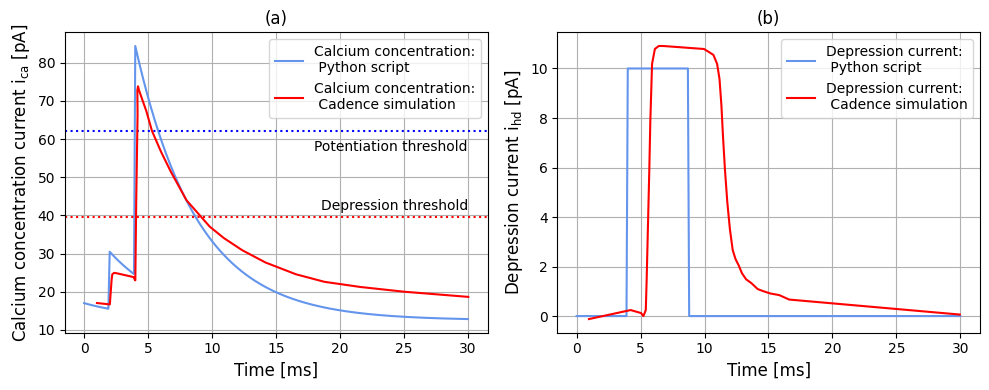

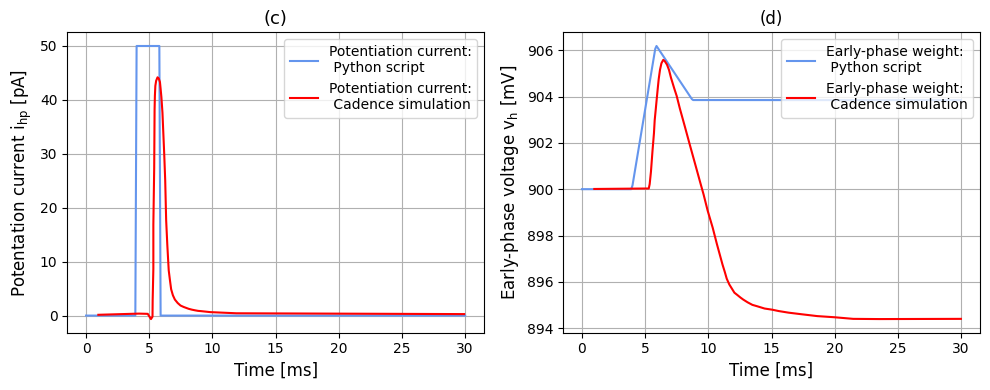

In [ ]:
ihdd1, ihpp1 = np.array(ihdd) * 10**12, np.array(ihpp) * 10**12
# Plotting the first graph
fig, axs = plt.subplots(1,2, figsize=(10, 4), sharex=True)

# First subplot
i_ca_pA = np.array(i_ca) * 10**12
t_ms = np.array(t) * 1000
axs[0].plot(t_ms, i_ca_pA, color='cornflowerblue', label='Calcium concentration:\n Python script')
axs[0].axhline(y=I_THDEP*10**12, color='red', linestyle=':')#, label = 'Depression threshold')
axs[0].axhline(y=I_THPOT*10**12, color='blue', linestyle=':')#, label = 'Potentiation threshold')
axs[0].plot(x,y, color='r', label='Calcium concentration:\n Cadence simulation')
axs[0].text(30, 1+I_THDEP*10**12, 'Depression threshold', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=10)
axs[0].text(30, -6+I_THPOT*10**12, 'Potentiation threshold', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=10)
axs[0].set_title("(a)", fontsize=12)
axs[0].set_xlabel("Time [ms]", fontsize=12)
axs[0].set_ylabel(r"Calcium concentration current i$_{\mathrm{ca}}$ [pA]", fontsize=12)
axs[0].legend()
axs[0].grid()

axs[1].set_title("(b)", fontsize=12)
axs[1].plot(t_ms, -ihdd1, color='cornflowerblue', label='Depression current:\n Python script')
axs[1].set_ylabel(r"Depression current i$_{\mathrm{hd}}$ [pA]", fontsize=12)
axs[1].set_xlabel("Time [ms]", fontsize=12)
axs[1].grid()
axs[1].plot(xd, yd, color = 'r', label='Depression current:\n Cadence simulation')
axs[1].legend()








plt.tight_layout()
plt.show()


# Plotting the first graph
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)


# First subplot
axs[0].plot(t_ms, ihpp1, color='cornflowerblue', label='Potentiation current:\n Python script')
axs[1].set_xlabel("Time [ms]", fontsize=12)
axs[0].set_title("(c)", fontsize=13)
axs[0].set_xlabel("Time [ms]", fontsize=12)
axs[0].set_ylabel(r"Potentation current i$_{\mathrm{hp}}$ [pA]", fontsize=12)
axs[0].grid()
axs[0].plot(xp, yp, color = 'r', label='Potentiation current:\n Cadence simulation')
axs[0].legend()

# Plotting the second graph in the second subplot
axs[1].plot(t_ms, v_h*1000, color='cornflowerblue', label='Early-phase weight:\n Python script')
# plt.axhline(y=I_THDEP*10**12, color='grey', linestyle='-.')
# plt.axhline(y=I_THPOT*10**12, color='grey', linestyle='-.')
# plt.text(30, 1+I_THDEP*10**12, 'Threshold for depression', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=13)
# plt.text(30, 1+I_THPOT*10**12, 'Threshold for potentiation', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=13)
#plt.title("Variation in early-phase voltage \n in response to a continuous random spiking input", fontsize=13)
axs[1].set_xlabel("Time [ms]", fontsize=12)
axs[1].set_title('(d)')
axs[1].set_ylabel(r"Early-phase voltage v$_{\mathrm{h}}$ [mV]", fontsize=12)  # Using LaTeX syntax for subtext
axs[1].plot(xe, ye, color = 'r',  label='Early-phase weight:\n Cadence simulation')
axs[1].legend(loc = 'upper right')
axs[1].grid()
plt.tight_layout()

In [ ]:
print(len(t_ms))

301


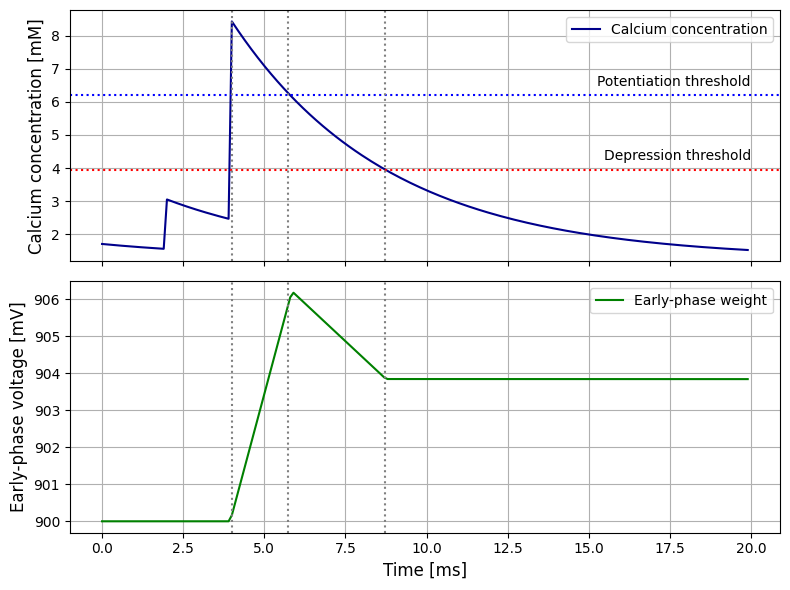

In [ ]:
ihdd1, ihpp1 = np.array(ihdd) * 10**12, np.array(ihpp) * 10**12
# Plotting the first graph
fig, axs = plt.subplots(2,1, figsize=(8, 6), sharex=True)

# First subplot
i_ca_pA = np.array(i_ca) * 10**11
t_ms = np.array(t) * 1000
axs[0].plot(t_ms[:200], i_ca_pA[:200], color='darkblue', label='Calcium concentration')
axs[0].axhline(y=I_THDEP*10**11, color='red', linestyle=':')#, label = 'Depression threshold')
axs[0].axhline(y=I_THPOT*10**11, color='blue', linestyle=':')#, label = 'Potentiation threshold')
# axs[0].plot(x,y, color='r', label='Calcium concentration:\n Cadence simulation')
axs[0].text(20, 0.2+I_THDEP*10**11, 'Depression threshold', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=10)
axs[0].text(20, 0.2+I_THPOT*10**11, 'Potentiation threshold', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=10)
# axs[0].set_title("(a)", fontsize=12)
# axs[0].set_xlabel("Time [ms]", fontsize=12)
axs[0].set_ylabel(r"Calcium concentration [mM]", fontsize=12)
axs[0].legend()
axs[0].grid()
for x_value in [4, 5.73, 8.73]:
    axs[0].axvline(x=x_value, color='grey', linestyle=':')





# Plotting the second graph in the second subplot
axs[1].plot(t_ms[:200], v_h[:200]*1000, color='green', label='Early-phase weight')
# plt.axhline(y=I_THDEP*10**12, color='grey', linestyle='-.')
# plt.axhline(y=I_THPOT*10**12, color='grey', linestyle='-.')
# plt.text(30, 1+I_THDEP*10**12, 'Threshold for depression', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=13)
# plt.text(30, 1+I_THPOT*10**12, 'Threshold for potentiation', ha='right', va='bottom', color='black', rotation='horizontal', fontsize=13)
#plt.title("Variation in early-phase voltage \n in response to a continuous random spiking input", fontsize=13)
axs[1].set_xlabel("Time [ms]", fontsize=12)
# axs[1].set_title('(d)')
axs[1].set_ylabel(r"Early-phase voltage [mV]", fontsize=12)  # Using LaTeX syntax for subtext
# axs[1].plot(xe, ye, color = 'r',  label='Early-phase weight:\n Cadence simulation')
axs[1].legend(loc = 'upper right')
axs[1].grid()
for x_value in [4, 5.73, 8.73]:
    plt.axvline(x=x_value, color='grey', linestyle=':')


plt.tight_layout()